# Рынок предприятий общественного питания Москвы

## Описание проекта
Исследование рынка заведений общественного питания в Москве, выполненный на основе открытых данных.      
Цель - подготовка презентации для инвесторов для обсуждения перспектив отрытия нового кафе.

In [1]:
import pandas as pd                   # загружаем библиотеки
import numpy as np
import datetime as dt

import re                             # регулярные выражения

import matplotlib.pyplot as plt       # графики
import seaborn as sns

In [2]:
# снимаем ограничения на ширину колонок
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150

## Содержание

### [Предобработка данных](#data)
   - #### [Проверка дубликатов](#dup)
   - #### [Проверка данных по категории "Посадочные места = 0"](#null)
   - #### [Итоги предобработки данных](#data_fin)
   
### [Анализ данных](#data_analys)
   - #### [Соотношение видов объектов общественного питания по их количеству](#count)
   - #### [Соотношение сетевых и несетевых заведений по количеству](#chain)
   - #### [Типы объектов общественного питания характерные для сетевой и несетевой структуры](#type)
   - #### [Характерные особенности сетевых предприятий](#type_chain)
   - #### [Среднее количество посадочных мест для каждого типа объекта общественного питания](#mean)
   - #### [Информация об улицах местонахождения объектов](#street)
   - #### [Топ-10 улиц по количеству объектов общественного питания](#street_10)
   - #### [Улицы с одним объектом общественного питания](#street_1)
   - #### [Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания](#street_10_count)
   
### [Итоги анализа данных](#end_analys)
   
### [Рекомендации по развитию проекта](#recomend)

## Предобработка данных <a name="data"></a>
- Сведения о заведениях общественного питания г.Москвы. 
- Описание
    - `id` - учетный номер объекта
    - `object_name` — название объекта общественного питания;
    - `chain` — сетевой ресторан;
    - `object_type` — тип объекта общественного питания;
    - `address` — адрес;
    - `number` — количество посадочных мест.

In [3]:
rest_data = pd.read_csv('rest_data.csv')
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [4]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


В базе 15366 записей, пропущенных значений нет, типы данных соответсвуют столбцам - два столбца целочисленные записи, остальное строки.

In [5]:
rest_data.columns          # проверим на лишние пропуски названия колонок

Index(['id', 'object_name', 'chain', 'object_type', 'address', 'number'], dtype='object')

In [6]:
rest_data.describe()  # описание числовых данных

,id,number
count,15366.000000,15366.000000
mean,119720.066901,59.547182
std,73036.130732,74.736833
min,838.000000,0.000000
25%,28524.000000,12.000000
50%,144974.500000,40.000000
75%,184262.250000,80.000000
max,223439.000000,1700.000000


В колонке значений "количество мест" есть нулевые записи (не пропуски), и аномально большие выбросы.

In [7]:
rest_data.object_type.unique()  # типы заведений в базе

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

In [8]:
rest_data.chain.unique()   # значения принадлежности к сетевой структуре

array(['нет', 'да'], dtype=object)

### Проверка дубликатов <a name="dup"></a>

In [9]:
rest_data.duplicated().sum() # проверка дубликатов

0

В общем дубликатов нет, но в поиске дубликатов может мешать `id` заведения. Проверим дубликаты по адресам.

In [10]:
rest_data.duplicated(['address']).sum()  # дубликаты по адресам

6258

Возможно на одном адресе могут быть несколько заведений, проверим по названиям.

In [11]:
rest_data.duplicated(['address', 'object_name']).sum()  # дубликаты по адресам и названиям

207

Для каждого заведения может быть разные виды обслуживания `object_type`

In [12]:
rest_data.duplicated(['address', 'object_type', 'object_name']).sum()

171

В принципе тоже допустимо - осталось ограничить количеством посадочных мест, маловероятно что такие дубликаты это совпадение. Сначала проверим дубликаты без учета посадочных мест.

In [13]:
rest_data[rest_data.duplicated(['address', 'object_type', 'object_name'])]

,id,object_name,chain,object_type,address,number
115,28614,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,буфет,"город Москва, Бригадирский переулок, дом 3-5",12
580,149205,Общественное питание,нет,кафе,"город Москва, Павелецкая площадь, дом 1",35
581,149131,Общественное питание,нет,кафе,"город Москва, Павелецкая площадь, дом 1",39
1409,151267,Альфорно,нет,кафе,"город Москва, город Зеленоград, корпус 438",45
2375,28604,КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА,нет,столовая,"город Москва, 2-я Бауманская улица, дом 5, строение 1",150
...,...,...,...,...,...,...
15173,218542,Кофе с собой,да,предприятие быстрого обслуживания,"город Москва, Алтуфьевское шоссе, дом 70, корпус 1",0
15216,214468,Макдоналдс,да,предприятие быстрого обслуживания,"город Москва, Варшавское шоссе, дом 87Б",0
15217,214146,Макдоналдс,да,предприятие быстрого обслуживания,"город Москва, Кировоградская улица, дом 13А",0
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20


Есть вариант что данные по посадочным местах могли заносится неточно, или в зависимости от сезонности, или других факторов количество мест на самом деле меняется. Проверим данные по нескольким названиям.

In [14]:
rest_data[rest_data['object_name'] == 'Общественное питание'] 

,id,object_name,chain,object_type,address,number
576,149218,Общественное питание,нет,кафе,"город Москва, Павелецкая площадь, дом 1",40
579,149227,Общественное питание,нет,столовая,"город Москва, Павелецкая площадь, дом 1",70
580,149205,Общественное питание,нет,кафе,"город Москва, Павелецкая площадь, дом 1",35
581,149131,Общественное питание,нет,кафе,"город Москва, Павелецкая площадь, дом 1",39
8071,149389,Общественное питание,нет,кафе,"город Москва, Павелецкая площадь, владение 1, сооружение 1",15


In [15]:
rest_data[rest_data['object_name'] == 'Шоколадница']  

,id,object_name,chain,object_type,address,number
72,21830,Шоколадница,да,кафе,"город Москва, Бауманская улица, дом 33/2, строение 1",48
136,25608,Шоколадница,да,кафе,"город Москва, Бутырская улица, дом 7",25
231,76765,Шоколадница,да,кафе,"город Москва, Кудринская площадь, дом 1",50
247,25654,Шоколадница,да,кафе,"город Москва, Большая Никитская улица, дом 24/1, строение 1",50
275,59356,Шоколадница,да,кафе,"город Москва, Тверская улица, дом 19",48
...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское шоссе, 22-й километр, домовладение 4, строение 1",36


Два варианта общепита, "дубликаты" с разным количеством мест находятся на территориях рядом с вокзалами - Павелецким и Курским.
Там вполне возможно расположение по одному адресу разных точек одной сети (как Шоколадница) с разным количеством мест. Что касается "Общественного питания" - это общее название для мелких ИП (вероятно), возможно это одно и тоже место (где разница в 1 стул - 39 и 40), а возможно нет. Может быть "Вареничная" и, на другом конце дома, "Блинная".   

В любом случае для общего количества данных одна или две лишнии записи не будут иметь особого значения. **Оставляем более жесткое ограничениие на дубликаты, добавим в фильтр количество мест**. Можно было удалять дубликаты не учитывая количество мест и оставлять одно заведение (первое или последнее значение, через аргумент - `keep=`), но по вышеописанной логике это неправильно.

In [16]:
rest_data[rest_data['object_name'] == 'Старый Баку']   # пример дубликата

,id,object_name,chain,object_type,address,number
9750,169761,Старый Баку,нет,ресторан,"город Москва, Грайвороновская улица, дом 12, корпус 1",92
14577,222885,Старый Баку,нет,кафе,"город Москва, Кировоградская улица, владение 15А",120
14578,222932,Старый Баку,нет,кафе,"город Москва, Кировоградская улица, владение 15А",120


In [17]:
# целевые фильтры для отбора дубликатов - название, адрес, количество посадочных мест.
rest_data.duplicated(['address', 'object_name', 'number']).sum()

87

In [18]:
rest_data.drop_duplicates(['address', 'object_name', 'number'], inplace=True)
rest_data.duplicated(['address', 'object_name', 'number']).sum()

0

In [19]:
rest_data[rest_data['object_name'] == 'Старый Баку']    # проверка 

,id,object_name,chain,object_type,address,number
9750,169761,Старый Баку,нет,ресторан,"город Москва, Грайвороновская улица, дом 12, корпус 1",92
14577,222885,Старый Баку,нет,кафе,"город Москва, Кировоградская улица, владение 15А",120


Дубликаты удалены

### Проверка данных по категории "Посадочные места = 0"<a name="null"></a>

In [20]:
number_null = rest_data['number'] == 0   #нет посадочных мест
rest_data[number_null]

,id,object_name,chain,object_type,address,number
137,115498,Пекарня & Донер,нет,закусочная,"город Москва, Бутырская улица, дом 9, корпус 2",0
154,152556,Шаурма в пите,нет,предприятие быстрого обслуживания,"город Москва, Варшавское шоссе, дом 72, корпус 2",0
157,149568,Суши,нет,предприятие быстрого обслуживания,"город Москва, улица Маршала Василевского, дом 3, корпус 1",0
190,126956,"Шаурма, куры-гриль",нет,предприятие быстрого обслуживания,"город Москва, 1-я Владимирская улица, дом 21",0
195,149531,"Шаурма, куры-гриль",нет,предприятие быстрого обслуживания,"город Москва, 2-я Владимирская улица, дом 44/10",0
...,...,...,...,...,...,...
15334,211228,МИЛТИ,да,магазин (отдел кулинарии),"город Москва, Дубравная улица, дом 34/29",0
15335,211221,МИЛТИ,да,магазин (отдел кулинарии),"город Москва, Пятницкое шоссе, дом 3",0
15336,211209,Готовые блюда Милти,да,предприятие быстрого обслуживания,"город Москва, Ореховый бульвар, дом 22А",0
15337,208477,Милти,да,предприятие быстрого обслуживания,"город Москва, 3-й Крутицкий переулок, дом 18",0


*В части предприятий такая ситуация вполне допустима, в этих вариантах точно - "закусочная", "предприятие быстрого обслуживания" и "магазин (отдел кулинарии)".* 

In [21]:
rest_data.object_type.unique()  # все виды предприятий в базе

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

In [22]:
print('Всего доля записей с нулевым количеством мест: {:.2%}'.format(len(rest_data[number_null]) / len(rest_data)))

Всего доля записей с нулевым количеством мест: 10.39%


Исключим из отбора варианты, по которым мы установили допустимость отсутствия посадочных мест.

In [23]:
# категории для фильтрации
object_type_null = ['предприятие быстрого обслуживания', 'закусочная', 'магазин (отдел кулинарии)']

# данные по нулевым посадлочным местам после фильтрации
rest_data.loc[(number_null) & (~rest_data['object_type'].isin(object_type_null))]

,id,object_name,chain,object_type,address,number
206,150836,ГБОУ Школа №1468,нет,столовая,"город Москва, Волгоградский проспект, дом 17, строение 1",0
504,157035,Кофе с собой,да,кафетерий,"город Москва, Краснохолмская набережная, дом 13, строение 1",0
577,149220,Кофейня «Кофе Хаус»,да,кафе,"город Москва, Павелецкая площадь, дом 1А, строение 1",0
802,142581,Кофе Энигма,нет,кафе,"город Москва, Овчинниковская набережная, дом 22/24, строение 1",0
1003,149427,Французская пекарня,нет,кафетерий,"город Москва, Русаковская улица, дом 29",0
...,...,...,...,...,...,...
15278,211218,Милти,да,кафе,"город Москва, Зеленодольская улица, дом 33, корпус 1, строение 2",0
15287,211416,Милти,да,кафе,"город Москва, Сормовская улица, дом 6",0
15288,211205,Милти,да,кафе,"город Москва, Сокольническая площадь, дом 9А",0
15290,211204,Милти,да,кафе,"город Москва, улица Стромынка, дом 25, строение 1",0


Записей осталось 571. "Милти" считается сетевым кафе, но по сути позиционирования это приготовление еды на вынос (так во всяком случае на сайте написано). Либо это точки без мест, либо это точки расположенные на фудкортах ТЦ. Можно отбросить МИЛТИ из этих данных.

In [24]:
(
    rest_data.loc[(number_null) 
                  & (~rest_data['object_type'].isin(object_type_null) 
                     & (rest_data['object_name'] != 'Милти'))]
)

,id,object_name,chain,object_type,address,number
206,150836,ГБОУ Школа №1468,нет,столовая,"город Москва, Волгоградский проспект, дом 17, строение 1",0
504,157035,Кофе с собой,да,кафетерий,"город Москва, Краснохолмская набережная, дом 13, строение 1",0
577,149220,Кофейня «Кофе Хаус»,да,кафе,"город Москва, Павелецкая площадь, дом 1А, строение 1",0
802,142581,Кофе Энигма,нет,кафе,"город Москва, Овчинниковская набережная, дом 22/24, строение 1",0
1003,149427,Французская пекарня,нет,кафетерий,"город Москва, Русаковская улица, дом 29",0
...,...,...,...,...,...,...
15236,219130,KFC,да,ресторан,"город Москва, улица Вавилова, дом 3",0
15246,214867,KFC,да,кафе,"город Москва, Кутузовский проспект, дом 57",0
15252,222677,Чайхона №1,да,кафе,"город Москва, Мячковский бульвар, дом 3А",0
15253,214872,Чайхона №1,да,кафе,"город Москва, Кутузовский проспект, дом 57",0


In [25]:
rest_data.loc[(number_null) & (rest_data['object_name'] == 'KFC')]              # пример данных по сети KFC

,id,object_name,chain,object_type,address,number
5718,156398,KFC,да,предприятие быстрого обслуживания,"город Москва, Святоозерская улица, дом 1А",0
5973,134575,KFC,да,предприятие быстрого обслуживания,"город Москва, Поречная улица, дом 10",0
8754,154534,KFC,да,ресторан,"город Москва, Хорошёвское шоссе, дом 27",0
12068,94597,KFC,да,ресторан,"город Москва, Ходынский бульвар, дом 4",0
12083,176827,KFC,да,предприятие быстрого обслуживания,"город Москва, Семёновская площадь, дом 1",0
13472,203842,KFC,да,кафе,"город Москва, Ленинский проспект, дом 109",0
15236,219130,KFC,да,ресторан,"город Москва, улица Вавилова, дом 3",0
15244,210743,KFC,да,предприятие быстрого обслуживания,"город Москва, город Московский, улица Хабарова, дом 2",0
15246,214867,KFC,да,кафе,"город Москва, Кутузовский проспект, дом 57",0


В списках с нулевым количеством мест есть сетевые предприятия, при ближайшем рассмотрении по адресу расположения, эти точки находятся с торговых центрах. Т.е вероятно это фудкорты где нет четко выделенных зон с количеством мест для каждого сетевого предприятия. Можем также убрать такие предприятия из фильтрации нулевых мест.

In [26]:
# не сетевые предприятия
chain_no = rest_data['chain'] == 'нет' 
rest_data.loc[(number_null) & (~rest_data['object_type'].isin(object_type_null)) & (chain_no)]

,id,object_name,chain,object_type,address,number
206,150836,ГБОУ Школа №1468,нет,столовая,"город Москва, Волгоградский проспект, дом 17, строение 1",0
802,142581,Кофе Энигма,нет,кафе,"город Москва, Овчинниковская набережная, дом 22/24, строение 1",0
1003,149427,Французская пекарня,нет,кафетерий,"город Москва, Русаковская улица, дом 29",0
1018,21413,ИНТЕРМЕДСЕРВИС,нет,буфет,"город Москва, Садовая-Каретная улица, дом 20, строение 2",0
1229,155493,Шаурма24,нет,кафетерий,"город Москва, Флотская улица, дом 36",0
...,...,...,...,...,...,...
14959,219124,Калимера,нет,кафе,"город Москва, Хорошёвское шоссе, дом 27",0
14967,210764,Дейли Шеф,нет,ресторан,"город Москва, город Московский, улица Хабарова, дом 2",0
14970,214114,Армянский лаваш,нет,кафе,"город Москва, поселение Воскресенское, посёлок Воскресенское, дом 40, корпус 2",0
14978,213725,Выпечка,нет,кафе,"город Москва, поселение Воскресенское, деревня Ямонтово, владение 71",0


Определим не сетевые точки общепита расположенные в торговых центрах по дубликатам адресов расположения. 

In [27]:
rest_number_null = (
                    rest_data.loc[(number_null) 
                        & (~rest_data['object_type'].isin(object_type_null)) & (chain_no)]
)
# заведения НЕ сетевые расположенные в торговых центрах, 
# т.е вероятно не имеющие конкретного количество посадочных мест
rest_number_null[rest_number_null.duplicated('address')]

,id,object_name,chain,object_type,address,number
4491,152299,Фудмаркет. Грачева,нет,ресторан,"город Москва, улица Новый Арбат, дом 21",0
4492,152305,Фудмаркет. Шапиро,нет,ресторан,"город Москва, улица Новый Арбат, дом 21",0
4493,152307,Фудмаркет. Салпагарова,нет,ресторан,"город Москва, улица Новый Арбат, дом 21",0
4501,152255,Фудмаркет.Швыдкой,нет,ресторан,"город Москва, улица Новый Арбат, дом 21",0
4502,152222,Фудмаркет.Паритова,нет,ресторан,"город Москва, улица Новый Арбат, дом 21",0
...,...,...,...,...,...,...
14944,222551,Krispy Kreme,нет,кафе,"город Москва, Ходынский бульвар, дом 4",0
14952,222448,Kuvings,нет,бар,"город Москва, Хорошёвское шоссе, дом 27",0
14956,219102,Salateria,нет,кафе,"город Москва, Хорошёвское шоссе, дом 27",0
14957,219103,ВьетПапа,нет,кафе,"город Москва, Хорошёвское шоссе, дом 27",0


Почти половина из несетевых предприятий с нулевыми местами расположена по адресам ТЦ (фудкортов, фудмаркетов). Проверим количество предприятий общепита не относящихся к сетевым структурам и расположенные не в ТЦ и т.п.

In [28]:
# заведение расположенные НЕ по массовым адресам
rest_number_null[~rest_number_null.duplicated('address')]

,id,object_name,chain,object_type,address,number
206,150836,ГБОУ Школа №1468,нет,столовая,"город Москва, Волгоградский проспект, дом 17, строение 1",0
802,142581,Кофе Энигма,нет,кафе,"город Москва, Овчинниковская набережная, дом 22/24, строение 1",0
1003,149427,Французская пекарня,нет,кафетерий,"город Москва, Русаковская улица, дом 29",0
1018,21413,ИНТЕРМЕДСЕРВИС,нет,буфет,"город Москва, Садовая-Каретная улица, дом 20, строение 2",0
1229,155493,Шаурма24,нет,кафетерий,"город Москва, Флотская улица, дом 36",0
...,...,...,...,...,...,...
14951,222442,OnePriceCoffe,нет,кафетерий,"город Москва, Хорошёвское шоссе, дом 27",0
14967,210764,Дейли Шеф,нет,ресторан,"город Москва, город Московский, улица Хабарова, дом 2",0
14970,214114,Армянский лаваш,нет,кафе,"город Москва, поселение Воскресенское, посёлок Воскресенское, дом 40, корпус 2",0
14978,213725,Выпечка,нет,кафе,"город Москва, поселение Воскресенское, деревня Ямонтово, владение 71",0


In [29]:
print('Доля записей с нулевым количеством мест\nдля заведений с немассовым адресом: {:.2%}'.format(
                len(rest_number_null[~rest_number_null.duplicated('address')]) / len(rest_data)))

Доля записей с нулевым количеством мест
для заведений с немассовым адресом: 1.79%


Процент данных с неопределенным количеством посадочных мест достаточно низкий, вряд ли такой процент неопределенности как то существенно повлияет на окончательные выводы. Проверим возможно ли каким то образом заполнить отсутствующую информацию по некоторым предприятиям где явно должны быть посадочные места.

In [30]:
rest_data[rest_data['object_name'] == 'ГБОУ Школа №1468']

,id,object_name,chain,object_type,address,number
206,150836,ГБОУ Школа №1468,нет,столовая,"город Москва, Волгоградский проспект, дом 17, строение 1",0
4737,150838,ГБОУ Школа №1468,нет,столовая,"город Москва, Рабочая улица, дом 10",0
4739,150833,ГБОУ Школа №1468,нет,столовая,"город Москва, Рабочая улица, дом 35, корпус 2",0
4740,150835,ГБОУ Школа №1468,нет,столовая,"город Москва, Вековая улица, дом 10",0
4750,150834,ГБОУ Школа №1468,нет,столовая,"город Москва, Волгоградский проспект, дом 11, корпус 2",0
8228,150837,ГБОУ Школа №1468,нет,столовая,"город Москва, Нижегородская улица, дом 19",0


Все данные по посадочным местам столовой школы Школа №1468 отсутствуют, на сайте школы тоже нет. Такая же ситуаций с Шаурмой24, в этом случае действительно может не быть посадочных мест.

In [31]:
rest_data.loc[rest_data['object_name'] == 'Шаурма24']

,id,object_name,chain,object_type,address,number
1229,155493,Шаурма24,нет,кафетерий,"город Москва, Флотская улица, дом 36",0
11491,180962,Шаурма24,нет,предприятие быстрого обслуживания,"город Москва, Нагатинская улица, дом 16",0


In [32]:
rest_data.loc[rest_data['object_name'] == 'PhoBo']

,id,object_name,chain,object_type,address,number
1927,149337,PhoBo,нет,кафе,"город Москва, улица Рождественка, дом 5/7, строение 2",36
10156,172769,PhoBo,нет,кафе,"город Москва, Ленинградское шоссе, дом 16А, строение 8",20
15024,210136,PhoBo,нет,кафе,"город Москва, поселение Московский, Киевское шоссе, 23-й километр, дом 1, строение 1",0


"PhoBo" - необязательно, что по последнему адресу вообще есть посадочные места, тем более что это автовокзал.

In [33]:
rest_data.loc[rest_data['object_name'] == 'Французская пекарня']

,id,object_name,chain,object_type,address,number
225,25447,Французская пекарня,нет,кафе,"город Москва, Воронцовская улица, дом 48",25
686,128970,Французская пекарня,нет,кафе,"город Москва, проспект Мира, дом 47, строение 1",16
940,153091,Французская пекарня,нет,кафетерий,"город Москва, Профсоюзная улица, дом 13/12",12
1003,149427,Французская пекарня,нет,кафетерий,"город Москва, Русаковская улица, дом 29",0
1923,137429,Французская пекарня,нет,кафе,"город Москва, улица Сретенка, дом 27, строение 1",20
9127,160259,Французская пекарня,нет,кафе,"город Москва, улица Миклухо-Маклая, дом 47А",8
10229,183336,Французская пекарня,нет,кафе,"город Москва, улица Маршала Бирюзова, дом 16",10
10557,189211,Французская пекарня,нет,кафе,"город Москва, Южнопортовая улица, дом 18",8
11228,174841,Французская пекарня,нет,магазин (отдел кулинарии),"город Москва, улица Молостовых, дом 1Д, строение 2",2
12285,204844,Французская пекарня,нет,кафетерий,"город Москва, проспект Андропова, дом 21",20


По данным из французской пекарни можно заполнить типичное число посадочных мест из  категории кафетерий - 12 мест.

In [34]:
rest_data.loc[rest_data['object_name'] == 'Французская пекарня', 'number'] = (
rest_data.loc[rest_data['object_name'] == 'Французская пекарня', 'number'].replace(0, 12)
)

In [35]:
rest_data.loc[rest_data['object_name'] == 'Французская пекарня']  # проверка

,id,object_name,chain,object_type,address,number
225,25447,Французская пекарня,нет,кафе,"город Москва, Воронцовская улица, дом 48",25
686,128970,Французская пекарня,нет,кафе,"город Москва, проспект Мира, дом 47, строение 1",16
940,153091,Французская пекарня,нет,кафетерий,"город Москва, Профсоюзная улица, дом 13/12",12
1003,149427,Французская пекарня,нет,кафетерий,"город Москва, Русаковская улица, дом 29",12
1923,137429,Французская пекарня,нет,кафе,"город Москва, улица Сретенка, дом 27, строение 1",20
9127,160259,Французская пекарня,нет,кафе,"город Москва, улица Миклухо-Маклая, дом 47А",8
10229,183336,Французская пекарня,нет,кафе,"город Москва, улица Маршала Бирюзова, дом 16",10
10557,189211,Французская пекарня,нет,кафе,"город Москва, Южнопортовая улица, дом 18",8
11228,174841,Французская пекарня,нет,магазин (отдел кулинарии),"город Москва, улица Молостовых, дом 1Д, строение 2",2
12285,204844,Французская пекарня,нет,кафетерий,"город Москва, проспект Андропова, дом 21",20


Для более детального анализа нет смысла, количество неопределенных данных в этой категории = 1,8%, малая величина, слабо повлияющая на выводы.

### Итоги предобработки данных <a name="data_fin"></a>

- В базе 15 366 записей, пропущенных значений нет, типы данных соответсвуют столбцам - два столбца целочисленные записи, остальное текстовые данные. 
- В колонке значений "количество мест" есть нулевые записи (не пропуски), и аномально большие выбросы.
- Полных дубликатов нет (из-за поля `id` заведения). Поиск дубликатов по параметрам: адрес, название, количество посадочных мест, т.е по наиболее полному списку возможных совпадений выявил 142 записи. Такие данные менее 1% от всего объема. Только по названиям общего порядка типа "Общественного питания" нельзя понять однозначно принадлежность к одному и тому же заведению.
- Удалили дубликаты по условиям в которые вошли все поля кроме `id`..

#### Данные по категории "Посадочные места == 0"
- Всего доля записей с нулевым количеством мест: 10.39%.
- По сути деятельности для некоторых заведений такая практика вполне допустима, например для "закусочных", "предприятий быстрого обслуживания" и "магазин (отдел кулинарии)".
- В остальные 571 записи входят сетевые и несетевые заведения в том числе расположенные по адресам ТЦ, фудкортов и фудмаркетов. 
- По немассовым адресам (не ТЦ) доля записей с нулевым количеством мест составляет 1.79%, что достаточно салый показатель. Вряд ли такой процент неопределенности как-то существенно повлияет на окончательные выводы. 

## Анализ данных <a name="data_analys"></a>

###  Соотношение видов объектов общественного питания по их количеству<a name="count"></a>

In [36]:
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [37]:
rest_data['object_type'].unique()  # данные для подписи оси х на графике

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

#### График "Количество предприятий общественного питания по типу объекта"

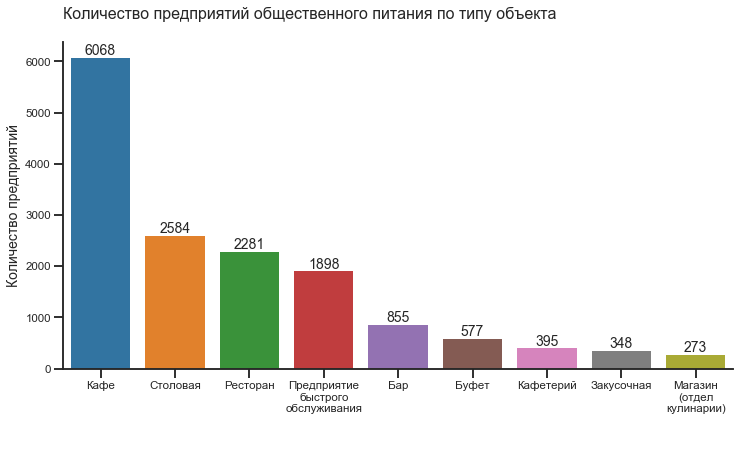

In [38]:
plt.style.use('seaborn-white')
sns.set_context('talk', font_scale = 0.7)

plt.figure(figsize =(12, 6))
ax = sns.countplot(x='object_type', data = rest_data,
              order = rest_data['object_type'].value_counts().index)                    # cортировка по убыванию
# убираем лишние оси
sns.despine()

plt.title('Количество предприятий общественного питания по типу объекта\n', 
          fontdict={'size': 16}, loc='left')
plt.ylabel('Количество предприятий', fontdict={'size': 14})
plt.xlabel(' ', fontdict={'size': 14})

# делаем подписи под графиком
N = 9
ind = np.arange(N)
plt.xticks(ind, ('Кафе', 'Столовая', 'Ресторан', 'Предприятие\nбыстрого\nобслуживания\n ', 
                 'Бар', 'Буфет', 'Кафетерий', 'Закусочная', 'Магазин\n(отдел\nкулинарии)\n'))

# текст над столбцами
for i, object_type in enumerate(rest_data['object_type'].value_counts()):
    ax.text(i, object_type, round(object_type, 1), horizontalalignment='center', 
                                                   verticalalignment='bottom', fontsize=14)

plt.savefig('object_type.png', dpi=200) # сохраняем график в файл для презентации;

In [39]:
rest_data['object_type'].value_counts()

кафе                                 6068
столовая                             2584
ресторан                             2281
предприятие быстрого обслуживания    1898
бар                                   855
буфет                                 577
кафетерий                             395
закусочная                            348
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

In [40]:
rest_data['object_type'].value_counts().sum()

15279

Больше всего в базе зарегистировано "Кафе" - 6068 шт., следующая тройка наиболее массовый сегмент "Столовая"(2584), "Ресторан"(2281), "Предриятие быстрого питания"(1898), замыкает список, с примерно равными долями - "Кафетерий"(395), "Закусочная"(348), "Магазин (отдел кулинарии)"(273). 

### Соотношение сетевых и несетевых заведений по количеству<a name="chain"></a>

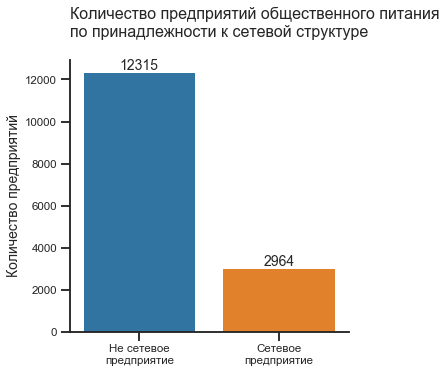

In [41]:
plt.style.use('seaborn-white')
sns.set_context('talk', font_scale = 0.7)

plt.figure(figsize =(5, 5))
ax = sns.countplot(x='chain', data = rest_data, 
              order = rest_data['chain'].value_counts().index)  # cортировка по убыванию
sns.despine()
plt.title('Количество предприятий общественного питания\nпо принадлежности к сетевой структуре\n', 
          fontdict={'size': 16}, loc='left')
plt.ylabel('Количество предприятий', fontdict={'size': 14})
plt.xlabel('',  fontdict={'size': 14})

# делаем подписи под графиком
N = 2
ind = np.arange(N)
plt.xticks(ind, ('Не сетевое\nпредприятие', 'Сетевое\nпредприятие'))

# текст над столбцами
for i, chain in enumerate(rest_data['chain'].value_counts()):
    ax.text(i, chain, round(chain, 1), horizontalalignment='center', 
                                       verticalalignment='bottom', fontsize=14)

plt.savefig('chain_type.png', dpi=200) # сохраняем график в файл для презентации;

Для презентации сохраним график Сетевых и несетевых предприятий в долях от общего объема. Совместим его с графиком количества предприятий общественного питания по типам и по принадлежности к сетевой структуре, легенду и подписи добавим в презентации.

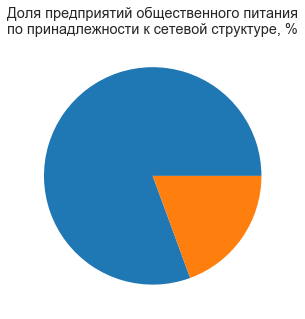

In [42]:
plt.style.use('seaborn-white')
sns.set_context('talk', font_scale = 0.8)

plt.figure(figsize =(5, 5))

plt.pie(rest_data['chain'].value_counts())

plt.title('Доля предприятий общественного питания\nпо принадлежности к сетевой структуре, %')
plt.ylabel("")

plt.savefig('chain_type_pie.png', dpi=200, transparent=True) # сохраняем график в файл для презентации;

In [43]:
rest_data['chain'].value_counts()

нет    12315
да      2964
Name: chain, dtype: int64

Сетевых предприятий 19% от общего объема записе в базе.

### Типы объектов общественного питания характерные для сетевой и несетевой структуры<a name="type"></a>

Потребуется подготовить данные для подписи графиков, построенных с помощью `hue`

In [44]:
# данные по количеству и типам предприятий не сетевого формата
rest_data[rest_data['chain'] == 'нет']['object_type'].value_counts()

кафе                                 4672
столовая                             2581
ресторан                             1738
предприятие быстрого обслуживания    1110
бар                                   818
буфет                                 566
кафетерий                             343
закусочная                            292
магазин (отдел кулинарии)             195
Name: object_type, dtype: int64

In [45]:
# сформируем таблицу с данными по количеству и типам предприятий не сетевого формата
# сохраним исходную сортировку
for_sort = rest_data[rest_data['chain'] == 'нет']['object_type'].value_counts().reset_index()
for_sort.columns = ['object_type', 'chain_no'] 
for_sort

,object_type,chain_no
0,кафе,4672
1,столовая,2581
2,ресторан,1738
3,предприятие быстрого обслуживания,1110
4,бар,818
5,буфет,566
6,кафетерий,343
7,закусочная,292
8,магазин (отдел кулинарии),195


In [46]:
# сформируем таблицу с данными по количеству и типам предприятий сетевого формата
to_sort = rest_data[rest_data['chain'] == 'да']['object_type'].value_counts().reset_index()
to_sort.columns =  ['object_type', 'chain_yes'] 
to_sort

,object_type,chain_yes
0,кафе,1396
1,предприятие быстрого обслуживания,788
2,ресторан,543
3,магазин (отдел кулинарии),78
4,закусочная,56
5,кафетерий,52
6,бар,37
7,буфет,11
8,столовая,3


In [47]:
# объединим две таблицу с сохранением нужной нам сортировки данных
# из нее будем брать информацию для обозначений на графике значений 
for_sort = for_sort.merge(to_sort, how='left', on='object_type')
for_sort

,object_type,chain_no,chain_yes
0,кафе,4672,1396
1,столовая,2581,3
2,ресторан,1738,543
3,предприятие быстрого обслуживания,1110,788
4,бар,818,37
5,буфет,566,11
6,кафетерий,343,52
7,закусочная,292,56
8,магазин (отдел кулинарии),195,78


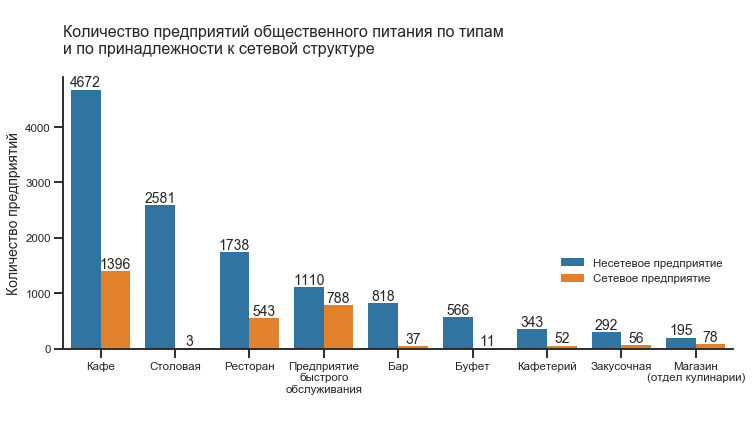

In [48]:
plt.style.use('seaborn-white')
sns.set_context('talk', font_scale = 0.7)

plt.figure(figsize =(12, 5))
ax = sns.countplot(x='object_type', data=rest_data, hue='chain', 
                   order = rest_data['object_type'].value_counts().index)                      # cортировка по убыванию
# убираем лишние оси
sns.despine()

plt.title(' \nКоличество предприятий общественного питания по типам\nи по принадлежности к сетевой структуре\n', 
          fontdict={'size': 16}, loc='left')
plt.ylabel('Количество предприятий', fontdict={'size': 14})
plt.xlabel('  ', fontdict={'size': 14})

plt.legend(['Несетевое предприятие', 'Сетевое предприятие'], 
                                       loc='lower right', bbox_to_anchor=(1., 0.2, 0, 0))

# текст над столбцами
for i, object_type in enumerate(rest_data[rest_data['chain'] == 'нет']['object_type'].value_counts()):
    ax.text(i-0.20, object_type, round(object_type, 1), horizontalalignment='center', 
                                                   verticalalignment='bottom', fontsize=14)

for i, chain_yes in enumerate(for_sort['chain_yes']):
    ax.text(i+0.20, chain_yes, round(chain_yes, 1), horizontalalignment='center', 
                                                   verticalalignment='bottom', fontsize=14)
# делаем подписи под графиком
N = 9
ind = np.arange(N)
plt.xticks(ind, ('Кафе', 'Столовая', 'Ресторан', 'Предприятие\nбыстрого\nобслуживания\n ', 
                 'Бар', 'Буфет', 'Кафетерий', 'Закусочная', 'Магазин\n(отдел кулинарии)'))

plt.savefig('object_type_chain.png', dpi=200, bbox_inches='tight') # сохраняем график в файл для презентации;

**В основном сетевыми являются кафе, ресторан, предприятия быстрого питания (наименование часто используемое именно большими компаниями типа МакДоналдс, КFC и т.п.). По остальным типам предприятий единичные случаи сетевых принадлежностей**.

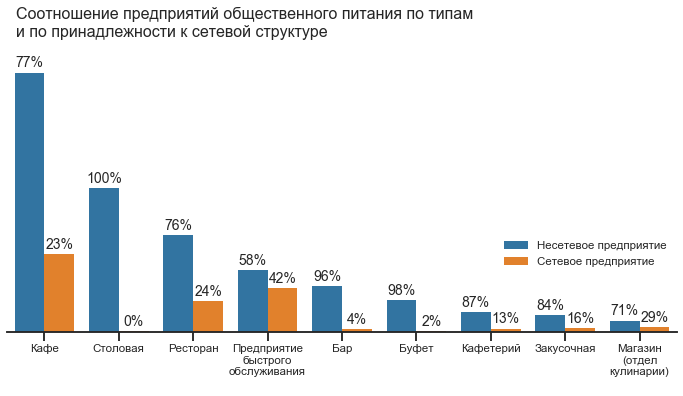

In [49]:
plt.style.use('seaborn-white')
sns.set_context('talk', font_scale = 0.7)

plt.figure(figsize =(12, 5))
ax = sns.countplot(x='object_type', data=rest_data, hue='chain', 
                   order = rest_data['object_type'].value_counts().index)                      # cортировка по убыванию
# убираем лишние оси
sns.despine(left=True)

plt.title('  Соотношение предприятий общественного питания по типам\n  и по принадлежности к сетевой структуре\n', 
          fontdict={'size': 16}, loc='left')
plt.ylabel('')
plt.xlabel('')
plt.yticks([])

plt.legend(['Несетевое предприятие', 'Сетевое предприятие'], 
                                       loc='lower right', bbox_to_anchor=(1., 0.2, 0, 0))

# подписи в % над столбцами
bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r

    ax.text(left.get_x() + left.get_width()/2., height_l + 100, '{0:.0%}'.format(height_l/total), ha="center", fontsize=14)
    ax.text(right.get_x() + right.get_width()/2., height_r + 100, '{0:.0%}'.format(height_r/total), ha="center", fontsize=14)


# делаем подписи под графиком
N = 9
ind = np.arange(N)
plt.xticks(ind, ('Кафе', 'Столовая', 'Ресторан', 'Предприятие\nбыстрого\nобслуживания\n ', 
                 'Бар', 'Буфет', 'Кафетерий', 'Закусочная', 'Магазин\n(отдел\nкулинарии)'))

plt.savefig('object_type_chain_pr.png', dpi=200, bbox_inches='tight'); # сохраняем график в файл для презентации

### Характерные особенности сетевых предприятий<a name="type_chain"></a>

Рассмотрим какое количество посадочных мест характерно для разных типов сетевых предприятий

In [50]:
rest_data.head() # исходная база

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


**График распределения сетевых предприятий общественного питания по количеству посадочных мест**

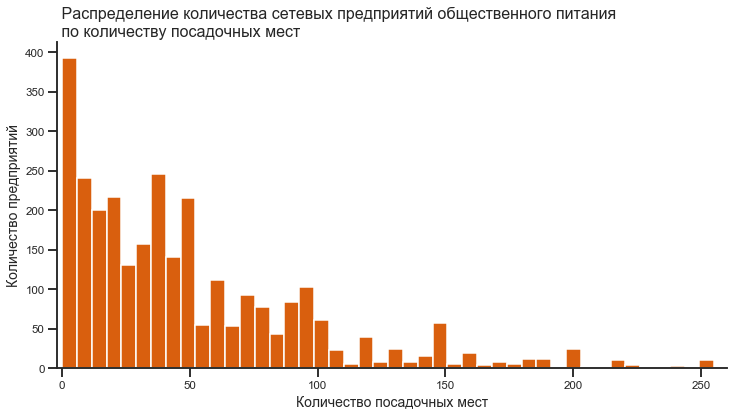

In [51]:
plt.figure(figsize=(12, 6))
plt.xlim(-2,260)
sns.set_style('white')

sns.distplot(rest_data.query('chain == "да"').number, 
             kde=False, bins=100, hist_kws = {'color':'#d95f0e', 'alpha':1.0})

plt.title(' Распределение количества сетевых предприятий общественного питания \n по количеству посадочных мест', 
          fontdict={'size': 16}, loc='left')
plt.ylabel('Количество предприятий', fontdict={'size': 14})
plt.xlabel('Количество посадочных мест', fontdict={'size': 14})

sns.despine()
plt.savefig('count_chain.png', dpi=200, bbox_inches='tight') # сохраняем график в файл для презентации;

Распределение ненормальное, поэтому наиболее типичное количество мест в сетевых заведениях покажет либо мода распределения, либо медиана

In [52]:
rest_data.query('chain == "да"').number.describe()

count    2964.000000
mean       52.981107
std        57.152817
min         0.000000
25%        15.000000
50%        40.000000
75%        72.000000
max       580.000000
Name: number, dtype: float64

Среднее значение (медиана) = 40

In [53]:
rest_data.query('chain == "да"').number.mode()

0    0
dtype: int64

Мода = 0 это те предприятия которые расположены на фудкортах в торговых центрах, конкуренция выше, затраты на аренду и содержания территории ниже. Судя по медиане характерное количество посадочных мест для сетевых предприятий - 40.  

**Для предприятий сетевого формата характерно большое количество заведений с малым количеством мест(около 40). В таких структурах единичные случаи предприятий с количеством мест более 150.**

**Рассмотрим подробнее 3 самых массовых типа предприятия в сетевом сегменте - Кафе, Ресторан, Предприятие быстрого обслуживания**

In [54]:
rest_data.query('chain == "да" & object_type == "кафе"').number.describe()

count    1396.000000
mean       47.426934
std        44.731453
min         0.000000
25%        20.000000
50%        40.000000
75%        60.000000
max       456.000000
Name: number, dtype: float64

In [55]:
# мода распределения посадочных мест в категории "кафе"
rest_data.query('chain == "да" & object_type == "кафе"').number.mode()

0    20
dtype: int64

In [56]:
rest_data.query('chain == "да" & object_type == "ресторан"').number.describe()

count    543.000000
mean     100.362799
std       74.442225
min        0.000000
25%       50.000000
50%       89.000000
75%      137.000000
max      500.000000
Name: number, dtype: float64

In [57]:
# мода распределения посадочных мест в категории "рестораны"
rest_data.query('chain == "да" & object_type == "ресторан"').number.mode()

0    50
dtype: int64

In [58]:
rest_data.query('chain == "да" & object_type == "предприятие быстрого обслуживания"').number.describe()

count    788.000000
mean      40.319797
std       50.738879
min        0.000000
25%        8.000000
50%       25.000000
75%       52.000000
max      580.000000
Name: number, dtype: float64

In [59]:
# мода распределения посадочных мест в категории "предприятие быстрого обслуживания"
rest_data.query('chain == "да" & object_type == "предприятие быстрого обслуживания"').number.mode()

0    0
dtype: int64

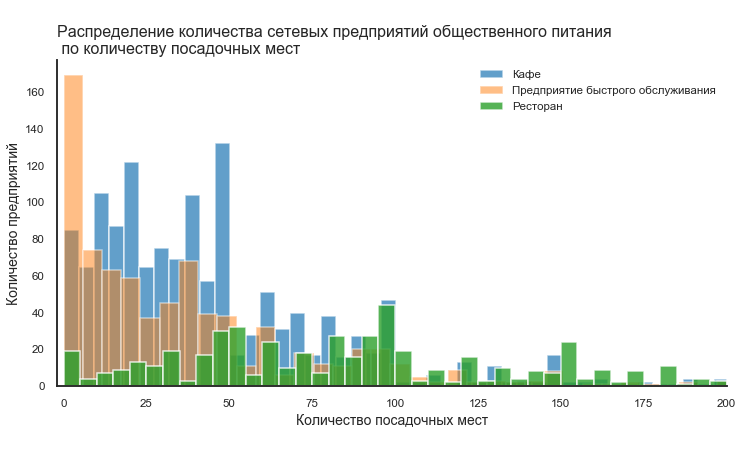

In [60]:
plt.figure(figsize=(12, 6))
plt.xlim(-2,200)
sns.set_style('white')
sns.set_context('talk', font_scale = 0.7)

sns.distplot(rest_data.query('chain == "да" & object_type == "кафе"').number, 
             kde=False, bins=100, hist_kws = {'alpha':0.7}, label='Кафе')
sns.distplot(rest_data.query('chain == "да" & object_type == "предприятие быстрого обслуживания"').number, 
             kde=False, bins=100, hist_kws = {'alpha':0.5}, label='Предприятие быстрого обслуживания')
sns.distplot(rest_data.query('chain == "да" & object_type == "ресторан"').number, 
             kde=False, bins=100, hist_kws = {'alpha':0.8}, label='Ресторан')

plt.title(' \nРаспределение количества сетевых предприятий общественного питания \n по количеству посадочных мест', 
          fontdict={'size': 16}, loc='left')
plt.ylabel('Количество предприятий', fontdict={'size': 14})
plt.xlabel('Количество посадочных мест\n', fontdict={'size': 14})
plt.legend(loc='best')

sns.despine()

plt.savefig('count_chain_top3.png', dpi=200, bbox_inches='tight') # сохраняем график в файл для презентации;

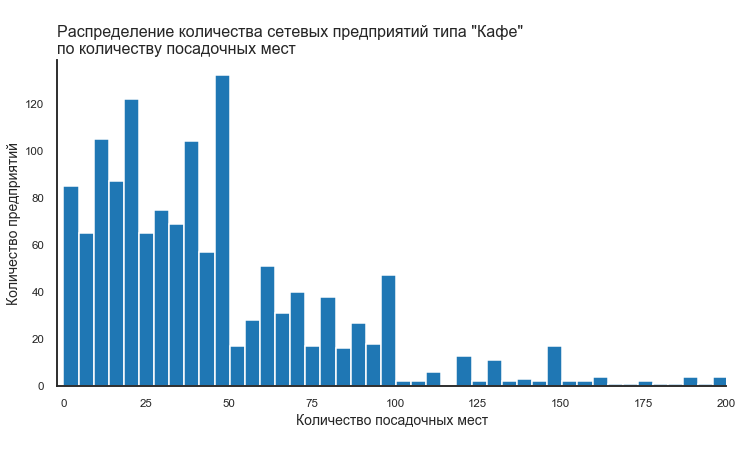

In [61]:
plt.figure(figsize=(12, 6))
plt.xlim(-2,200)
sns.set_style('white')
sns.set_context('talk', font_scale = 0.7)

sns.distplot(rest_data.query('chain == "да" & object_type == "кафе"').number, 
             kde=False, bins=100, hist_kws = {'alpha':1}, label='Кафе')

plt.title(' \nРаспределение количества сетевых предприятий типа "Кафе" \nпо количеству посадочных мест', 
          fontdict={'size': 16}, loc='left')
plt.ylabel('Количество предприятий', fontdict={'size': 14})
plt.xlabel('Количество посадочных мест\n', fontdict={'size': 14})
#plt.legend(loc='best')

sns.despine()
plt.savefig('count_chain_cafe.png', dpi=200, bbox_inches='tight') # сохраняем график в файл для презентации;

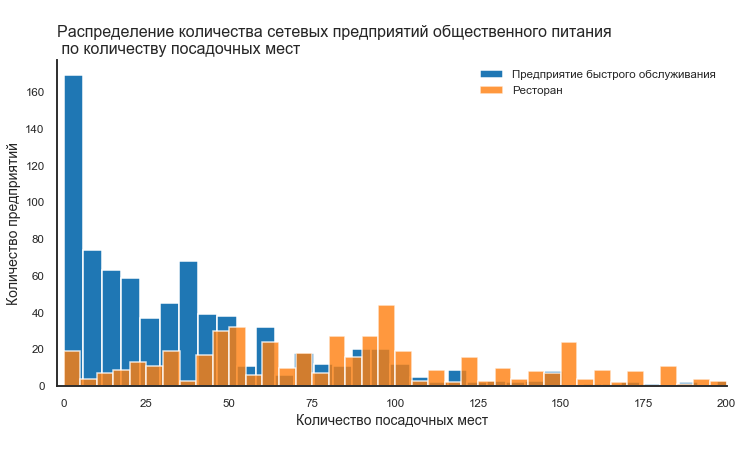

In [62]:
plt.figure(figsize=(12, 6))
plt.xlim(-2,200)
sns.set_style('white')
sns.set_context('talk', font_scale = 0.7)

sns.distplot(rest_data.query('chain == "да" & object_type == "предприятие быстрого обслуживания"').number, 
             kde=False, bins=100, hist_kws = {'alpha':1}, label='Предприятие быстрого обслуживания')
sns.distplot(rest_data.query('chain == "да" & object_type == "ресторан"').number, 
             kde=False, bins=100, hist_kws = {'alpha':0.8}, label='Ресторан')

plt.title(' \nРаспределение количества сетевых предприятий общественного питания \n по количеству посадочных мест', 
          fontdict={'size': 16}, loc='left')
plt.ylabel('Количество предприятий', fontdict={'size': 14})
plt.xlabel('Количество посадочных мест\n', fontdict={'size': 14})
plt.legend(loc='best')

sns.despine()
plt.savefig('count_chain_2_top3.png', dpi=200, bbox_inches='tight') # сохраняем график в файл для презентации;

- Для кафе наиболее типичным является 20-50 посадочных мест. 
- "Предприятие быстрого обслуживания" в большинстве своем не имеет своих посадочных мест так как это не предусмотрено форматом заведения или они располагаются в ТЦ и т.п. местах.
- Для ресторанов характерно 50-90 посадочных мест.

### Среднее количество посадочных мест для каждого типа объекта общественного питания<a name="mean"></a>

Рассмотрим как распределено среднее количество посадочных мест по типам предприятий.

In [63]:
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Рассчитаем значения среднего и медианы для каждого типа предприятия, выберем те значения которые более объективно, с точки зрения распределения данных отражают реальное положение дел.

In [64]:
rest_number_mean = rest_data.groupby('object_type').agg({'number':('mean', 'median')}).reset_index()
rest_number_mean.columns = ['object_type', 'number_mean', 'number_median']
rest_number_mean

,object_type,number_mean,number_median
0,бар,43.533333,35
1,буфет,51.509532,32
2,закусочная,7.801724,0
3,кафе,39.793507,30
4,кафетерий,9.245570,6
5,магазин (отдел кулинарии),5.589744,0
6,предприятие быстрого обслуживания,20.808219,6
7,ресторан,96.925033,80
8,столовая,130.337848,103


In [65]:
# среднее значение по количеству посадочных мест в заведениях Москвы.
rest_number_mean.number_median.median()

30.0

Выберем для показа данные по расчету медианы:

- при ненормальном распределении это более достоверный вариант, позволяет не учитывать аномальные выбросы справа
- при большом количестве (10%) данных с отсутствием посадочных мест значение среднего не покажет реальную ситуацию с такой категорией как "отдел кулинарии", "закусочная" 
- используя медиану мы получим более категоричную картину распределения посадочных мест.

In [66]:
# объединим две таблицу с сохранением нужной нам сортировки данных
# из нее будем брать информацию для обозначений на графике значений 
for_sort = for_sort.merge(rest_number_mean, how='left', on='object_type')
for_sort

,object_type,chain_no,chain_yes,number_mean,number_median
0,кафе,4672,1396,39.793507,30
1,столовая,2581,3,130.337848,103
2,ресторан,1738,543,96.925033,80
3,предприятие быстрого обслуживания,1110,788,20.808219,6
4,бар,818,37,43.533333,35
5,буфет,566,11,51.509532,32
6,кафетерий,343,52,9.245570,6
7,закусочная,292,56,7.801724,0
8,магазин (отдел кулинарии),195,78,5.589744,0


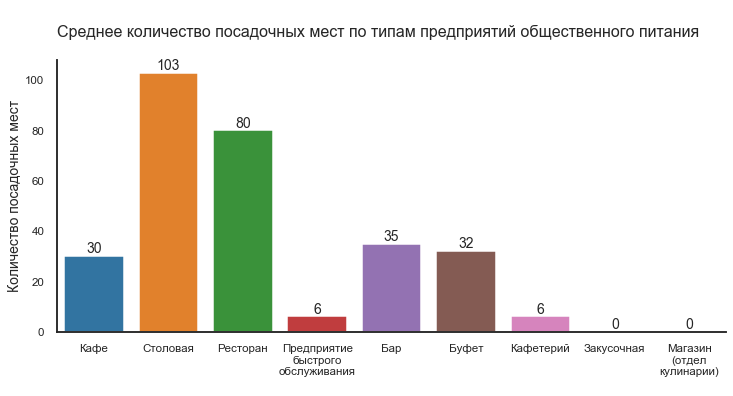

In [67]:
sns.set_style('white')
plt.figure(figsize =(12, 5))

ax = sns.barplot(x='object_type', y='number_median', data = rest_number_mean,
                order = rest_data['object_type'].value_counts().index)                           # cортировка по убыванию
# убираем лишние оси
sns.despine()

plt.title('\nСреднее количество посадочных мест по типам предприятий общественного питания\n', 
          fontdict={'size': 16}, loc='left')
plt.ylabel('Количество посадочных мест', fontdict={'size': 14})
plt.xlabel('', fontdict={'size': 14})

# подписи под графиком
N = 9
ind = np.arange(N)
plt.xticks(ind, ('Кафе', 'Столовая', 'Ресторан', 'Предприятие\nбыстрого\nобслуживания', 
                 'Бар', 'Буфет', 'Кафетерий', 'Закусочная', 'Магазин\n(отдел\nкулинарии)\n '))

# текст над столбцами
for i, number_median in enumerate(for_sort['number_median']):
    ax.text(i, number_median, round(number_median), horizontalalignment='center', 
                                                   verticalalignment='bottom', fontsize=14)

plt.savefig('object_type_number_mean.png', dpi=200, bbox_inches='tight') # сохраняем график в файл для презентации;

**ТОП-3 предприятий по количеству посадочных мест - Столовая (103), Ресторан (80), Бар/Буфет/Кафе (30-35, примерно одинаковое количество посадочных мест в среднем)**

### Информация об улицах местонахождения объектов<a name="street"></a>

In [68]:
rest_data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


Выделение названии улицы (ровно как и шоссе, переулка и т.п.) сделаем с помощью регулярных выражений путем очистки строк от остальной информации - номера домов, корпуса, сооружения и т.д. Фразу "город Москва" удалим, оставим наименования поселков и деревень ближайшего подмосковья. Путем простого разделения строки по запятым выделить улицы не получится так как не вся информация записана по шаблону. Удалим ненужную информация через замену на "ничего"

In [69]:
def func_street(data):

# убираем Москву
    data['street']=data['address'].replace(r'город Москва', '', regex=True)                             

# убираем все данные по домам, корпусам и т.д.
    data['street']=data['street'].replace(r'дом \d+[-+/0-9a-zA-Zа-яА-ЯёЁ]*', '', regex=True) 
    data['street']=data['street'].replace(r'корпус \w+[-+/0-9a-zA-Zа-яА-ЯёЁ]*', '', regex=True)
    data['street']=data['street'].replace(r'строение \d+[-+/0-9a-zA-Zа-яА-ЯёЁ]*', '', regex=True)
    data['street']=data['street'].replace(r'сооружение \d+[-+/0-9a-zA-Zа-яА-ЯёЁ]*', '', regex=True)
    data['street']=data['street'].replace(r'домовладение \d+[-+/0-9a-zA-Zа-яА-ЯёЁ]*', '', regex=True)
    data['street']=data['street'].replace(r'владение \d+[-+/0-9a-zA-Zа-яА-ЯёЁ]*', '', regex=True)

# убираем оставшиеся запятые в начале и в конце строки, 
# так чтобы оставить запятые в тексте где это необходимо
    data['street']=data['street'].replace(r'\B, ', '', regex=True)
    data['street']=data['street'].replace(r', \B', '', regex=True)

In [70]:
func_street(rest_data) # создаем столбец с улицами

In [71]:
rest_data.head()  # проверяем

,id,object_name,chain,object_type,address,number,street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


In [72]:
rest_data.street.unique().tolist()  # проверяем

['улица Егора Абакумова',
 'улица Талалихина',
 'Абельмановская улица',
 'Абрамцевская улица',
 'переулок Сивцев Вражек',
 'Авиамоторная улица',
 'улица Авиаторов',
 'Азовская улица',
 'Большая Академическая улица',
 'Филипповский переулок',
 'Алтайская улица',
 'Алтуфьевское шоссе',
 'улица Амундсена',
 'Анадырский проезд',
 'Ангарская улица',
 'проспект Андропова',
 'улица Арбат',
 'улица Артамонова',
 'Астраханский переулок',
 'Аэродромная улица',
 'Бабаевская улица',
 'улица Ивана Бабушкина',
 'Байкальская улица',
 'Бакинская улица',
 'Балаклавский проспект',
 '1-й Балтийский переулок',
 'улица Барклая',
 'Новая Басманная улица',
 'Бауманская улица',
 'Татарская улица',
 'Башиловская улица',
 'Беговая улица',
 'улица Демьяна Бедного',
 'Белореченская улица',
 'Бережковская набережная',
 'улица Берзарина',
 'Бескудниковский бульвар',
 'улица Бестужевых',
 'Бибиревская улица',
 'улица Маршала Бирюзова',
 'Бойцовая улица',
 'Болотниковская улица',
 'Коктебельская улица',
 'Ботаническа

Улицы все записаны в одном стиле (названия с большой буквы), перезаписывать для выявления похожих написаний смысла нет. Проверим методом подсчета уникальных значений - если общее количество уникальных значений не измениться после приведения всех названий к нижнему регистру то такого рода разных написаний в названиях улиц нет. Остальные проверики слишком затратны по времени. 

In [73]:
len(rest_data.street.unique())       # исходные записи

2043

In [74]:
rest_data['street_small'] = rest_data.street.str.lower()
len(rest_data['street_small'].unique())                 # исправленные записи

2043

Различий нет.

In [75]:
rest_data.drop('street_small', axis=1, inplace=True)
rest_data.head()

,id,object_name,chain,object_type,address,number,street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


### Топ-10 улиц по количеству объектов общественного питания<a name="street_10"></a>

In [76]:
# найдем первые 10 улиц по количеству предприятий на каждой,
# и запишем в отдельную таблицу
street_count = rest_data['street'].value_counts().head(10).reset_index()
street_count.columns = ['street', 'object_count']
street_count

,street,object_count
0,проспект Мира,204
1,Профсоюзная улица,182
2,Ленинградский проспект,172
3,Пресненская набережная,167
4,Варшавское шоссе,162
5,Ленинский проспект,148
6,город Зеленоград,129
7,проспект Вернадского,126
8,Кутузовский проспект,114
9,Каширское шоссе,111


In [77]:
street_top_10 = street_count.street.to_list()       # для подписи в графике
street_top_10

['проспект Мира',
 'Профсоюзная улица',
 'Ленинградский проспект',
 'Пресненская набережная',
 'Варшавское шоссе',
 'Ленинский проспект',
 'город Зеленоград',
 'проспект Вернадского',
 'Кутузовский проспект',
 'Каширское шоссе']

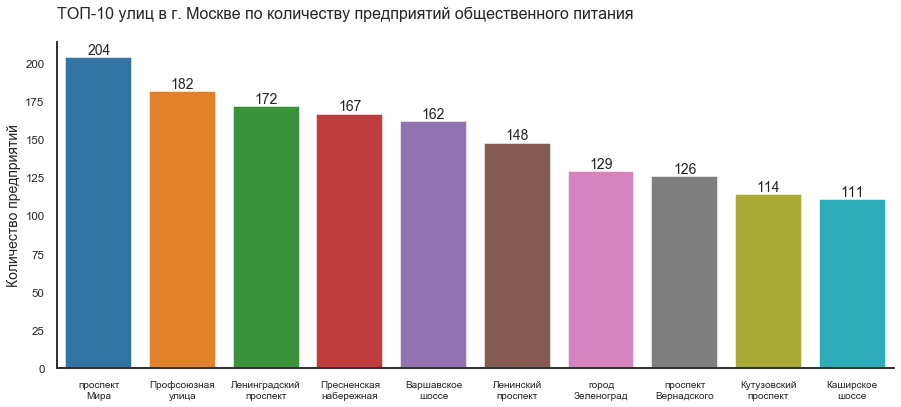

In [78]:
plt.figure(figsize =(15, 6))

ax = sns.barplot(x='street', y='object_count', data=street_count)  # cортировка по убыванию

sns.despine()

plt.title('ТОП-10 улиц в г. Москве по количеству предприятий общественного питания\n', 
          fontdict={'size': 16}, loc='left')
plt.ylabel('Количество предприятий', fontdict={'size': 14})
plt.xlabel('', fontdict={'size': 14})

# подписи под графиком
N = 10
ind = np.arange(N)
plt.xticks(ind, ('проспект\nМира', 'Профсоюзная\nулица', 'Ленинградский\nпроспект', 'Пресненская\nнабережная', 
                 'Варшавское\nшоссе', 'Ленинский\nпроспект', 'город\nЗеленоград', 'проспект\nВернадского', 
                 'Кутузовский\nпроспект', 'Каширское\nшоссе'), rotation=0, fontsize=10)

# текст над столбцами
for i, object_count in enumerate(street_count['object_count']):
    ax.text(i, object_count, round(object_count), horizontalalignment='center', 
                                                   verticalalignment='bottom', fontsize=14)

plt.savefig('street_count.png', dpi=200, bbox_inches='tight') # сохраняем график в файл для презентации;

Для определения района Москвы воспользуемся общедоступными данными (интернетом)
- проспект Мира - Северо-Восточный административный округ (СВАО), Алексеевский район
- Профсоюзная улица - Юго-Западный административный округ (ЮЗАО), район Коньково
- Ленинградский проспект - Северный административный округ (САО), Хорошёвский район
- Пресненская набережная - Центральный административный округ (ЦАО), Пресненский район
- Варшавское шоссе - Южный административный округ (ЮАО), район Чертаново Южное
- Ленинский проспект - Юго-Западный административный округ (ЮЗАО), Ломоносовский район
- город Зеленоград - Зеленоградский административный округ (ЗелАО)
- проспект Вернадского - Юго-Западный административный округ  (ЮЗАО), Ломоносовский район
- Кутузовский проспект - Западный административный округ (ЗАО), район Дорогомилово
- Каширское шоссе - Южный административный округ (ЮАО), район Москворечье-Сабурово

### Улицы с одним объектом общественного питания<a name="street_1"></a>

In [79]:
street_count = rest_data['street'].value_counts().reset_index()
street_count.columns = ['street', 'object_count']
len(street_count[street_count['object_count'] == 1])

634

Всего таких улиц 634, создадим отдельную базу по этим улицам и определим в каких округах они находятся

In [80]:
street_count_min = street_count[street_count['object_count'] == 1]
street_count_min.head()

,street,object_count
1409,Лениногорская улица,1
1410,3-я Песчаная улица,1
1411,Бродников переулок,1
1412,Делегатская улица,1
1413,улица Академика Арцимовича,1


**Для определения округов и районов Москвы для каждой улицы воспользуемся Адресным реестром объектов недвижимости города Москвы. (ПОРТАЛ ОТКРЫТЫХ ДАННЫХ Правительства Москвы (https://data.mos.ru/opendata/60562/data/table?versionNumber=3&releaseNumber=389)
База скачана и преобразована под задачу отдельно.**

In [81]:
# база по улицам Москвы, округам и муниципалитетам
data_moscow = pd.read_csv('moscow_street_adm_area.csv', sep='\t')
data_moscow.head()

,address,adm_area,district,street
0,"город Москва, Варшавское шоссе, дом 150, строение 2",Южный административный округ,муниципальный округ Чертаново Южное,Варшавское шоссе
1,"город Москва, Косинская улица, дом 26А",Восточный административный округ,муниципальный округ Вешняки,Косинская улица
2,"город Москва, Гороховский переулок, дом 21",Центральный административный округ,муниципальный округ Басманный,Гороховский переулок
3,"город Москва, Тагильская улица, дом 4, строение 36",Восточный административный округ,муниципальный округ Метрогородок,Тагильская улица
4,"город Москва, Ленинградский проспект, дом 73А, строение 3",Северный административный округ,муниципальный округ Сокол,Ленинградский проспект


In [82]:
data_moscow.drop(['address'], axis=1, inplace=True)   # удалим столбец полного адреса
data_moscow.drop_duplicates(inplace=True)             # удалим дубликаты для корректного объединия далее

In [83]:
# объединяем две таблицы нашу базу улиц и внешнюю (переделанную) базу по округам

street_count_min = street_count_min.merge(data_moscow, how='inner', on='street')
street_count_min.head()

,street,object_count,adm_area,district
0,Лениногорская улица,1,Восточный административный округ,муниципальный округ Косино-Ухтомский
1,3-я Песчаная улица,1,Северный административный округ,муниципальный округ Хорошевский
2,3-я Песчаная улица,1,Северный административный округ,муниципальный округ Сокол
3,Бродников переулок,1,Центральный административный округ,муниципальный округ Якиманка
4,Делегатская улица,1,Центральный административный округ,муниципальный округ Тверской


In [84]:
len(street_count_min)

585

В итоге данных немного меньше из-за адресов вне Москвы, не относящихся к какому-либо округу.

Определим сколько улиц с одним предприятием общественного питания в каждом округе Москвы.

In [85]:
street_count_min_plt = (
    street_count_min.groupby('adm_area').
                     agg({'object_count': 'sum'}).                        # суммирование улиц с одним заведением
                     sort_values(by='object_count', ascending=False).     # сортировка по убыванию
                     reset_index()
)
street_count_min_plt

,adm_area,object_count
0,Центральный административный округ,183
1,Восточный административный округ,69
2,Северо-Восточный административный округ,69
3,Северный административный округ,61
4,Юго-Восточный административный округ,58
5,Западный административный округ,43
6,Южный административный округ,35
7,Северо-Западный административный округ,30
8,Юго-Западный административный округ,30
9,Зеленоградский административный округ,7


In [86]:
street_count_min_plt.adm_area.to_list()

['Центральный административный округ',
 'Восточный административный округ',
 'Северо-Восточный административный округ',
 'Северный административный округ',
 'Юго-Восточный административный округ',
 'Западный административный округ',
 'Южный административный округ',
 'Северо-Западный административный округ',
 'Юго-Западный административный округ',
 'Зеленоградский административный округ']

In [87]:
street_count_min_plt.object_count.to_list()

[183, 69, 69, 61, 58, 43, 35, 30, 30, 7]

*Пересоберем таблицу, так как исходные данные не подгружаются*

In [88]:
adm_area = ['Центральный административный округ',                     # округа
             'Восточный административный округ',
             'Северо-Восточный административный округ',
             'Северный административный округ',
             'Юго-Восточный административный округ',
             'Западный административный округ',
             'Южный административный округ',
             'Северо-Западный административный округ',
             'Юго-Западный административный округ',
             'Зеленоградский административный округ']
object_count = [183, 69, 69, 61, 58, 43, 35, 30, 30, 7]              # количество улиц

street_count_min_plt = pd.DataFrame(list(zip(adm_area, object_count)), columns=['adm_area', 'object_count'])
street_count_min_plt

,adm_area,object_count
0,Центральный административный округ,183
1,Восточный административный округ,69
2,Северо-Восточный административный округ,69
3,Северный административный округ,61
4,Юго-Восточный административный округ,58
5,Западный административный округ,43
6,Южный административный округ,35
7,Северо-Западный административный округ,30
8,Юго-Западный административный округ,30
9,Зеленоградский административный округ,7


**График количества улиц с одним предприятием общественного питания по каждому округу г. Москвы**

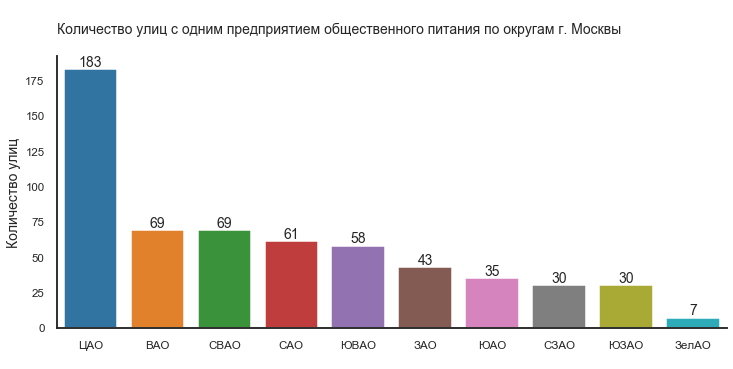

In [89]:
plt.figure(figsize =(12, 5))

ax = sns.barplot(x='adm_area', y='object_count', data=street_count_min_plt)  

sns.despine()

plt.title('\nКоличество улиц с одним предприятием общественного питания по округам г. Москвы\n', 
          fontdict={'size': 14}, loc='left')
plt.ylabel('Количество улиц', fontdict={'size': 14})
plt.xlabel('', fontdict={'size': 14})

# подписи под графиком
N = 10
ind = np.arange(N)
plt.xticks(ind, ('ЦАО', 'ВАО', 'СВАО', 'САО', 'ЮВАО', 'ЗАО', 'ЮАО', 'СЗАО', 
                 'ЮЗАО', 'ЗелАО\n'), rotation=0)

# текст над столбцами
for i, object_count in enumerate(street_count_min_plt['object_count']):
    ax.text(i, object_count, round(object_count), horizontalalignment='center', 
                                                   verticalalignment='bottom', fontsize=14)

plt.savefig('street_count_min.png', dpi=200, bbox_inches='tight') # сохраняем график в файл для презентации;

Выделяются три основные группы по количеству улиц с одним предприятием.
- Больше всего улиц с одним заведением в ЦАО - 183
- Четыре округа где 60-70 улиц - ВАО(69), СВАО(69), САО(61), ЮВАО(58) - восточная часть карты Москвы с Севера на ЮГ
- Четыре округа по 30-40 улиц - ЗАО(43), ЮАО(35), СЗАО(30), ЮЗАО(30) - западная часть карты с Севера на Юг.
Меньше всего таких улиц в Зеленограде - 7.

### Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания<a name="street_10_count"></a>

In [90]:
rest_data.query('street == @street_top_10').head()          # данные по предприятиям из списка ТОП-10 улиц

,id,object_name,chain,object_type,address,number,street
151,155973,Кафе «Андерсон»,да,кафе,"город Москва, Варшавское шоссе, дом 2",150,Варшавское шоссе
152,23618,Кафе «Subway»,да,кафе,"город Москва, Варшавское шоссе, дом 7, корпус 1",36,Варшавское шоссе
153,155852,Кафе «Ламаджо»,нет,кафе,"город Москва, Варшавское шоссе, дом 29",30,Варшавское шоссе
154,152556,Шаурма в пите,нет,предприятие быстрого обслуживания,"город Москва, Варшавское шоссе, дом 72, корпус 2",0,Варшавское шоссе
155,120658,Выпечка,нет,кафетерий,"город Москва, Варшавское шоссе, дом 100",2,Варшавское шоссе


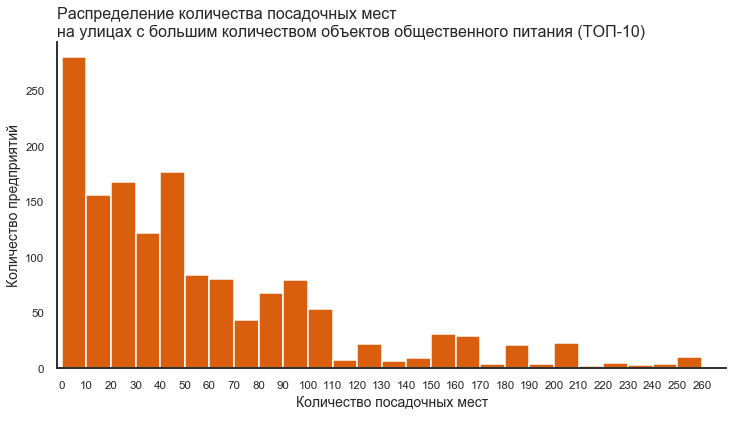

In [91]:
plt.figure(figsize=(12, 6))

# разметка оси Х по в соответствии с корзинами распределения
plt.xlim(-2,270)
bins = pd.Series(np.arange(0,270,10))  

sns.distplot(rest_data.query('street == @street_top_10').number, bins=bins,
             kde=False, hist_kws = {'color':'#d95f0e', 'alpha':1.0})

plt.title('Распределение количества посадочных мест\nна улицах с большим количеством\
 объектов общественного питания (ТОП-10)', 
          fontdict={'size': 16}, loc='left')

plt.ylabel('Количество предприятий', fontdict={'size': 14})
plt.xlabel('Количество посадочных мест\n', fontdict={'size': 14})
plt.xticks(bins)

sns.despine()
plt.savefig('street_top10.png', dpi=200, bbox_inches='tight') # сохраняем график в файл для презентации;

**Для наиболее загруженных улиц (по количеству точек питания) характерен формат заведений с количеством мест от 0 до 50. Если не рассматривать местоположение на общих фудкортах то большинство предприятий это 10-50 посадочых мест. Вероятно сильно зависит от района Москвы распределение по количеству мест.** 

**Рассмотрим Центральный округ - "Пресненская набережная"**

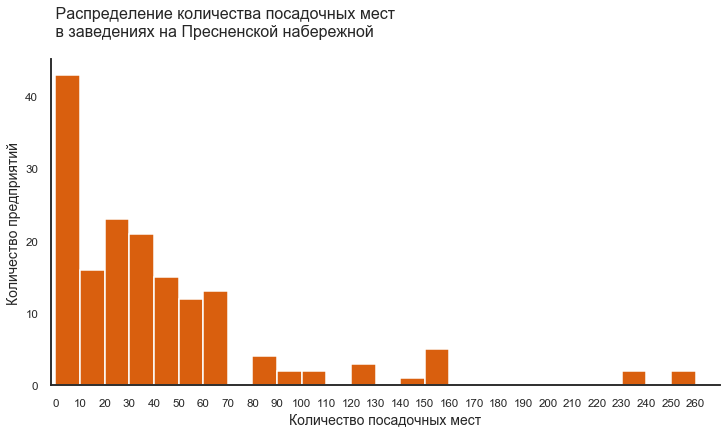

In [92]:
plt.figure(figsize=(12, 6))

# разметка оси Х по в соответствии с корзинами распределения
plt.xlim(-2,270)
bins = pd.Series(np.arange(0,270,10))  

sns.distplot(rest_data.query('street == "Пресненская набережная"').number, bins=bins,
             kde=False, hist_kws = {'color':'#d95f0e', 'alpha':1.0})

plt.title(' Распределение количества посадочных мест\n в заведениях на Пресненской набережной\n', 
          fontdict={'size': 16}, loc='left')

plt.ylabel('Количество предприятий', fontdict={'size': 14})
plt.xlabel('Количество посадочных мест', fontdict={'size': 14})
plt.xticks(bins)

sns.despine()
plt.savefig('street_presnya.png', dpi=200, bbox_inches='tight') # сохраняем график в файл для презентации;

**Рассмотрим Северо-Восточный округ - "Проспект Мира"**

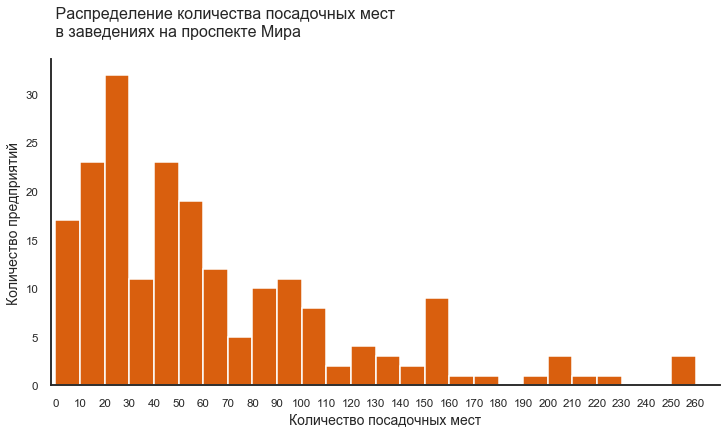

In [93]:
plt.figure(figsize=(12, 6))

# разметка оси Х по в соответствии с корзинами распределения
plt.xlim(-2,270)
bins = pd.Series(np.arange(0,270,10))  

sns.distplot(rest_data.query('street == "проспект Мира"').number, bins=bins,
             kde=False, hist_kws = {'color':'#d95f0e', 'alpha':1.0})

plt.title(' Распределение количества посадочных мест\n в заведениях на проспекте Мира\n', 
          fontdict={'size': 16}, loc='left')

plt.ylabel('Количество предприятий', fontdict={'size': 14})
plt.xlabel('Количество посадочных мест', fontdict={'size': 14})
plt.xticks(bins)

sns.despine()
plt.savefig('street_pospect.png', dpi=200, bbox_inches='tight') # сохраняем график в файл для презентации;

**Рассмотрим Северо-Восточный округ - "Профсоюзная улица"**

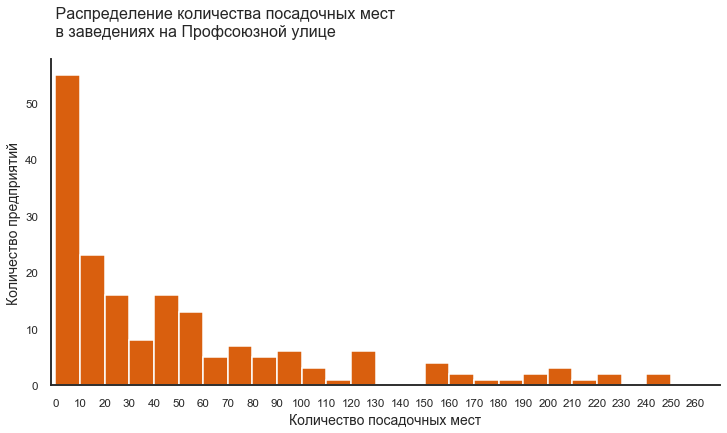

In [94]:
plt.figure(figsize=(12, 6))

# разметка оси Х по в соответствии с корзинами распределения
plt.xlim(-2,270)
bins = pd.Series(np.arange(0,270,10))  

sns.distplot(rest_data.query('street == "Профсоюзная улица"').number, bins=bins,
             kde=False, hist_kws = {'color':'#d95f0e', 'alpha':1.0})

plt.title(' Распределение количества посадочных мест\n в заведениях на Профсоюзной улице\n', 
          fontdict={'size': 16}, loc='left')

plt.ylabel('Количество предприятий', fontdict={'size': 14})
plt.xlabel('Количество посадочных мест', fontdict={'size': 14})
plt.xticks(bins)

sns.despine()
plt.savefig('street_prof.png', dpi=200, bbox_inches='tight') # сохраняем график в файл для презентации;

**Для улиц из ТОП-10 по количеству точек питания характерное количество посадочных мест зависит от района города. Общий график подтвердается точечными измерениями по трем самым загруженным улицам. Основная масса предприятий не имеют своих зон для рассадки гостей, на проспекте Мира больше заведений где от 10 до 50 мест.**

### Итоги анализа данных<a name="end_analys"></a>

Состав базы предприятий общественного питания
- Больше всего "Кафе" - 6068 шт.
- Следующая три типа, наиболее массовый сегмент, - "Столовая"(2584), "Ресторан"(2281), "Предприятие быстрого питания"(1898)
- Последние три, примерно равными долями, - "Кафетерий"(395), "Закусочная"(348), "Магазин (отдел кулинарии)"(273).

**В основном сетевыми предприятиями являются кафе, ресторан, предприятия быстрого питания.**

**Характерное количество посадочных мест для ТОП-3 типов сетевых предприятий**
- Для кафе наиболее типичным является 20-50 посадочных мест. 
- "Предприятие общественного питания" в большинстве своем не имеет своих посадочных мест, так как это не предусмотрено форматом заведения или они располагаются в ТЦ и т.п. местах.
- Для ресторанов характерно 50-90 посадочных мест.

**Среднее количество посадочных мест объектов общественного питания - ТОП-3.**
1. Столовая (100 мест), 
2. Ресторан (80 мест), 
3. Бар/Буфет/Кафе (30-35 мест, примерно одинаковое количество посадочных мест, в среднем)**

**ТОП-10 улиц в г. Москве по количество предприятий общественного питания.**
1. проспект Мира - Северо-Восточный административный округ (СВАО), Алексеевский район.
- Профсоюзная улица - Юго-Западный административный округ (ЮЗАО), район Коньково.
- Ленинградский проспект - Северный административный округ (САО), Хорошёвский район.
- Пресненская набережная - Центральный административный округ (ЦАО), Пресненский район.
- Варшавское шоссе - Южный административный округ (ЮАО), район Чертаново Южное.
- Ленинский проспект - Юго-Западный административный округ (ЮЗАО), Ломоносовский район.
- город Зеленоград - Зеленоградский административный округ (ЗелАО).
- проспект Вернадского - Юго-Западный административный округ  (ЮЗАО), Ломоносовский район.
- Кутузовский проспект - Западный административный округ (ЗАО), район Дорогомилово.
- Каширское шоссе - Южный административный округ (ЮАО), район Москворечье-Сабурово.

**Улицы с одним объектом.**   
Всего таких улиц 634. Для определения округов и районов Москвы для каждой улицы использовали Адресный реестр объектов недвижимости города Москвы. (ПОРТАЛ ОТКРЫТЫХ ДАННЫХ Правительства Москвы (https://data.mos.ru/opendata/60562/data/table?versionNumber=3&releaseNumber=389). Базу подготовили под задачу отдельно.

Выделяются три основные группы по количеству улиц с одним предприятием.
- Больше всего улиц с одним заведением в ЦАО - 183
- Четыре округа где 60-70 улиц - ВАО(69), СВАО(69), САО(61), ЮВАО(58) - восточная часть карты Москвы с Севера на ЮГ
- Четыре округа по 30-40 улиц - ЗАО(43), ЮАО(35), СЗАО(30), ЮЗАО(30) - западная часть карты с Севера на Юг.
Меньше всего таких улиц в Зеленограде - 7.

**Характерное количество посадочных мест на улицах из списка ТОП-10 по количеству заведений**    
Количество посадочных мест зависит от района города. Выводы по всем улицам подтверждаются более частными срезами данных по округам.
- Общая тенденция - количество посадочных мест от 0 до 50. 
- Если исключить локации в ТЦ, на фудкортах, фудмаркетах, то большинство предприятий это 10-50 посадочных мест. 
- Количество посадочных мест зависит от количества больших ТЦ в районе (округе) размещения предприятия.

##  Рекомендации по развитию проекта<a name="recomend"></a>

Отличительная особенность формата заведения – кафе, где посетителей обслуживают роботы официанты. Исходя из этого, рекомендации по запуску и развитию проекта могут быть такими:
- Формат "Кафе" наиболее точно подходит под идею.   
- Местоположение - Центральный или Восточные округа Москвы
- Улицы с малым количеством предприятий общественного питания (1+)
- Количество посадочных мест - 20-40
- Сетевая структура кафе

**Преимущества:**
1. **Меньше конкуренция:**
    - В центральном районе больше всего улиц с одним заведением. Далее по списку Восточные округа Москвы.
    - По Восточным округам в общем меньше количество заведений, чем в других округах.     


2. **Тип объекта и количество мест:**
    - Кафе, как отдельное помещение, предполагает свою ограниченную территорию для передвижения роботов. Размещение в ТЦ или фудкортах сложно организовать с технической точки зрения - нет "своей" территории для работы с гостями, соответственно нет необходимости в официантах.
    - Количество мест 20-50 - оптимальное для постоянного трафика, следовательно, и работы официантов. Если мест 0-20, то предполагается работа заведения с потоком гостей берущих товар "на вынос", такой формат похож на вендинговые автоматы для продажи еды.
    
    
3. **Сетевая структура предприятия приносит больше прибыли за счет централизованности закупок и масштабируемости бизнес решений.**

**Недостатки:**
1. **Стоимость:**
    - Отдельное помещение - дорогостоящее решение особенно в Центральном округе.
    - Сетевая структура требует больших начальных затрат.
    
    
2. **Ограничения по количеству мест:**
    - Количество мест 0-10 - вариант работы на фудкортах в ТЦ и т.п. более дешевый вариант запуска проекта. Но несет в себе риски материальные, а именно на такой "неограниченной" территории нельзя быть уверенным в антивандальных свойствах робота. Во всяком случае не на начальном этапе развитии проекта. Пока не будет отработана система работы в ограниченном пространстве - риски велики.
    
    
3. **Местоположение**
    - Требуется тщательный анализ местоположения (по улицам и районам), возможно есть какие-то скрытые причины низкой активности на улицах с одним предприятием.  
    - Высокая конкуренция на более оживленных улицах потребует бОльшего срока возврата инвестиций.
    
**Пояснения по части отсутствия посадочных мест.**
*Для сетевых проектов фудкорты и т.п. хорошая возможность старта, да и для несетевого проекта тоже. Это вероятно дешевле (зависит от места), возможностей выбрать местоположение больше. Текущие расходы меньше. Есть сетевые проекты которые совмещают и такой тип объекта, и классическое кафе (ресторан) в разных районах Москвы. Не берем в расчет крупных игроков, но например хинкальная "Вай Мэ!".*    
*Из того что нам изестно, о заданном проекте, размещение на фудкорте будет сравнимо с автоматом по выдаче еды, в лучшем случае, в худшем с недолгим и опасным развлечением с самоходными игрушками.*
